In [2]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

In [2]:
path = '1661-0.txt'
text = open(path, encoding='utf-8', errors='ignore').read().lower()
print('corpus length:', len(text))


corpus length: 581888


In [3]:
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

In [4]:
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

In [5]:
WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

['project', 'gutenberg', 's', 'the', 'adventures']
of


In [14]:
def data_generator(prev_words, next_words, unique_word_index, batch_size):
    num_samples = len(prev_words)
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    while True:
        for start_idx in range(0, num_samples, batch_size):
            batch_indices = indices[start_idx : start_idx + batch_size]
            batch_prev_words = [prev_words[idx] for idx in batch_indices]
            batch_next_words = [next_words[idx] for idx in batch_indices]

            X = np.zeros((len(batch_prev_words), WORD_LENGTH, len(unique_word_index)), dtype=bool)
            Y = np.zeros((len(batch_next_words), len(unique_word_index)), dtype=bool)

            for i, each_words in enumerate(batch_prev_words):
                for j, each_word in enumerate(each_words):
                    if j < WORD_LENGTH:
                        X[i, j, unique_word_index[each_word]] = 1
                Y[i, unique_word_index[batch_next_words[i]]] = 1

            yield X, Y

# Usage
batch_size = 64
generator = data_generator(prev_words, next_words, unique_word_index, batch_size)

# model.fit(generator, epochs=10, steps_per_epoch=len(prev_words) // batch_size)


In [15]:
print(X[0][0])

[False False False ... False False False]


In [16]:
# Building the Recurrent Neural network
model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

In [17]:
# Training the Next Word Prediction Model
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=2, shuffle=True).history

C:\Users\ATHARVA\anaconda3\lib\site-packages\keras\optimizers\legacy\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/2
811/811 [==============================] - 288s 347ms/step - loss: 5.9942 - accuracy: 0.1080 - val_loss: 7.0968 - val_accuracy: 0.0990
Epoch 2/2
811/811 [==============================] - 312s 384ms/step - loss: 5.7731 - accuracy: 0.1484 - val_loss: 7.8630 - val_accuracy: 0.1082


In [18]:
model.save('keras_next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('keras_next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

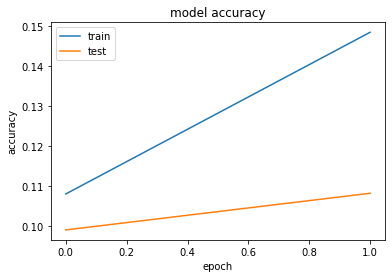

In [19]:
# Evaluating the Next Word Prediction Model
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

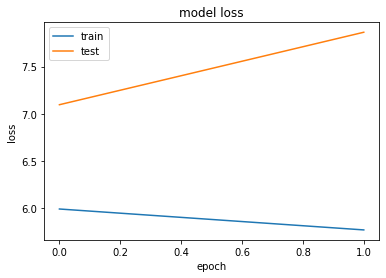

In [20]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [44]:
# Testing Next Word Prediction Model
SEQUENCE_LENGTH = 100
chars = sorted(list(set(text)))
char_indices = {char: i for i, char in enumerate(chars)}


def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x


In [45]:
prepare_input("This is an example of input for our LSTM".lower())

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [46]:
def prepare_input(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(text.split()):
        print(word)
        x[0, t, unique_word_index[word]] = 1
    return x
prepare_input("It is not a lack".lower())

it
is
not
a
lack


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [47]:
# create a function to return samples:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [48]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [49]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [50]:
quotes = [
    "When you meet someone special you'll know. Your heart will beat more rapidly and you'll smile for no reason."
    "they've decided its more fun if I don't."
    "So Tired D; Played Lazer Tag & Ran A LOT D; Ughh Going To Sleep Like In 5 Minutes ;)"
    "Words from a complete stranger! Made my birthday even better :)"
    "First Cubs game ever! Wrigley field is gorgeous. This is perfect. Go Cubs Go!"
]

In [51]:
for q in quotes:
    seq = q[:40].lower()
    completions = predict_completions(seq, 5)  # Get the completions
    num_completions = min(len(completions), 5)  # Adjust the number of completions if needed
    
    print(seq)
    for i in range(num_completions):
        print(completions[i])  # Print each completion
    print()


when
you
meet
someone
special
you'll


KeyError: "you'll"